Première tentative:

On doit chercher à inclure d'autres paramètres pour au moins égaler les performances du modèle Garch. Ici l'on se concentre tout d'abord sur le modèle naif construit arbitrairement sans ces autres paramètres en entrée.

On implémente le maximum de vraisemblance au lieu d'un erreur quadratique moyenne avec Tensorflow. Cela revient à changer la fonction coût dans l'implémentation du NN.
On maximise : $LL=\sum_{i=1}^{T}-\frac{1}{2}\log(\sigma_i^2)-\frac{r_i^2}{2\sigma_i^2}$ au lieu de l'erreur quadratique moyenne $MSE= \sum (\sigma_{\text{pred}}-\sigma_{\text{true}})^2$.
Pratiquement, on n'utilise pas de set de données de validation. Ce qui **SEMBLE** cohérent puisque la volatilité ne s'observe pas.

 Soit f sur $\mathbb{R}^{+*}$ par $f(\sigma_i)=-\frac{1}{2}\log(\sigma_i^2)-\frac{r_i^2}{2\sigma_i^2}$ alors
$$f(\sigma_i)\rightarrow_{\sigma_i\rightarrow +\infty}-\infty$$
$$f(\sigma_i)\rightarrow_{\sigma_i\rightarrow 0^+}\text{forme indéterminée}$$
Soit $\epsilon >0$ il existe un maximum de f sur $[\epsilon, +\infty[$
$$f(\sigma_i)'=(-\frac{1}{2}\log(\sigma_i^2)-\frac{r_i^2}{2\sigma_i^2})'=-\frac{1}{\sigma_i}+\frac{r_i^2}{\sigma_i^3}=0$$
$$\Leftrightarrow r_i^2-\sigma_i^2=0$$
Donc $r_i = \sigma_i$ au signe près. Quelque soit le modèle utilisé pour décrire le système, le maximum global de la vraisemblance est atteint en égalant le rendement (logique en réfléchissant 3sec y'avait pas besoin de tous ces calculs).

Deuxième tentative:

Soit $r_t|I_{t-1}\sim N(a_0+a_1*r_{t-1},\sigma_t^2)$. La vraisemblance s'écrit :
\begin{equation}
	L(\theta;r_1,\ldots,r_T)=\prod_{t=2}^T\frac{1}{\sqrt{2\pi\sigma_t^2}}\exp\left(-\frac{1}{2}\frac{(r_t-a_0-a_1*r_{t-1})^2}{\sigma_t^2}\right),
	% \in \Theta \subset \R^k.
\end{equation}
avec $\theta$ le vecteur des paramètres. La log-vraisemblance est :
\begin{eqnarray}
	l(\theta;r_1,\ldots,r_T)&=&\ln[L(\theta;r_1,\ldots,r_T)]\\
	&=&\sum_{t=2}^T\left[-\frac{1}{2}\ln(2\pi)-\frac{1}{2}\ln(\sigma_t^2)-\frac{1}{2}\frac{(r_t-a_0-a_1*r_{t-1})^2}{\sigma_t^2}\right]\\
	&=&-\frac{T-1}{2}\ln(2\pi)-\frac{1}{2}\sum_{t=2}^T\left[\ln(\sigma_t^2)\right]-\frac{1}{2}\sum_{t=2}^T\left[\frac{(r_t-a_0-a_1*r_{t-1})^2}{\sigma_t^2}\right].
\end{eqnarray}


In [ ]:
!pip install keras_tuner
!wget -q https://raw.githubusercontent.com/Undeavor/PE28/main/CREDITAGRICOLESA_2025-10-15.txt -O CA2.txt

In [ ]:
import pandas as pd
from pandas.plotting import autocorrelation_plot
from pandas_datareader import data
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import datetime
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras.models import Model
from keras.layers import *
from tensorflow.keras.utils import plot_model

In [ ]:
sp = pd.read_csv("/content/CA2.txt", sep="\t",usecols=["Date", "ouv", "haut", "bas", "Close", "vol", "devise"], parse_dates=["Date"], dayfirst=True )
print (sp.head())
print (sp.shape)

        Date     ouv    haut     bas   Close      vol devise
0 2005-10-17  23.078  23.172  22.899  23.040  2764750    EUR
1 2005-10-18  23.031  23.078  22.580  22.599  4425717    EUR
2 2005-10-19  22.467  22.608  22.223  22.241  4345454    EUR
3 2005-10-20  22.636  22.768  22.194  22.241  3568692    EUR
4 2005-10-21  22.091  22.420  22.091  22.138  2883072    EUR
(5119, 7)


In [ ]:
sp.Date = pd.to_datetime(sp.Date)
sp.dropna(inplace = True)
#on se limite au strict minimum de données pour l'instant : le prix de fermeture
sp.drop(columns = ["Date", "ouv", "haut", "bas", "vol", "devise"], inplace = True)
print (sp.head())
print (sp.shape)

    Close
0  23.040
1  22.599
2  22.241
3  22.241
4  22.138
(5119, 1)


    Close   returns  log_returns
1  22.599 -0.019141    -0.019326
2  22.241 -0.015841    -0.015968
3  22.241  0.000000     0.000000
4  22.138 -0.004631    -0.004642
5  22.617  0.021637     0.021406
(5118, 3)


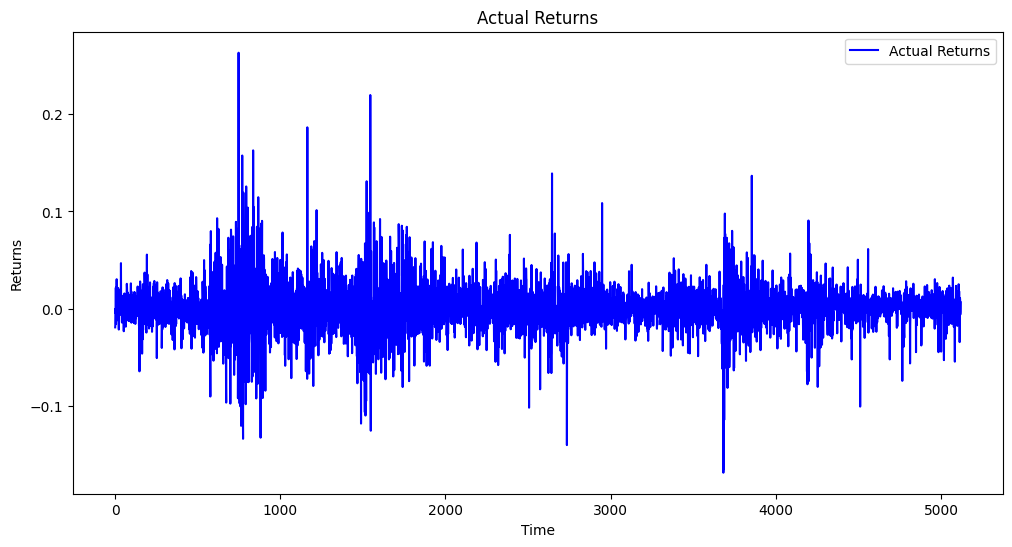

In [ ]:
sp['returns'] = sp['Close'].pct_change()
sp['log_returns'] = np.log(sp['Close'] / sp['Close'].shift(1))
sp.dropna(inplace = True)
print (sp.head())
print (sp.shape)
plt.figure(figsize=(12, 6))
plt.plot(sp.returns, label='Actual Returns', color='blue')
plt.title('Actual Returns')
plt.xlabel('Time')
plt.ylabel('Returns')
plt.legend()
plt.show()

X_train = sp['returns']
#X = sp['log_returns'].values.reshape(-1, 1)
y_train = sp['returns']

In [ ]:
#fonction d'erreur initiale
def mse(y_true, y_pred):
    return tf.reduce_mean(tf.square(y_true - y_pred))

"""#première tentative
#on considère que y_true vaut l'input, ie les rendements ( astuce )
def new_cost_function(y_true, y_pred):
    eps = 1e-8
    y_pred = tf.clip_by_value(y_pred, eps, 0.2)  # borne réaliste
    term1 = 0.5 * tf.math.log(y_pred)
    term2 = 0.5 * tf.square(y_true) / y_pred
    return tf.reduce_mean(term1 + term2)"""


#deuxième tentative
a0 = tf.Variable(0.0, trainable=True, dtype=tf.float32)
a1 = tf.Variable(0.0, trainable=True, dtype=tf.float32)
def gaussian_llh(y_true, sigma_raw):

    eps = 1e-8
    # sigma_t > 0 via softplus
    sigma = tf.nn.softplus(sigma_raw) + eps
    sigma2 = sigma**2

    # r_{t-1}
    r_tm1 = tf.concat([y_true[:1], y_true[:-1]], axis=0)

    # mu_t = a0 + a1 r_{t-1}
    mu = a0 + a1 * r_tm1

    return tf.reduce_mean(
        0.5 * tf.math.log(sigma2)
        + 0.5 * tf.square(y_true - mu) / (sigma2)
    )

In [ ]:
#ici mlp completement arbitraire
inputMLP = Input(shape=(1,))
x = Dense(128, activation='relu')(inputMLP)
x = Dropout(0.2)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(32, activation='relu')(x)
x = Dropout(0.2)(x)
output = Dense(1, name='volatility')(x)

mlp = Model(inputs=inputMLP, outputs=output)
mlp.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
    loss=new_cost_function
    #ici il faut enlever la ligne qui surveille l'erreur car elle n'a aucun sens
)
mlp.summary()

In [ ]:
#hist = lstm.fit(X_train, y_train,batch_size=20,epochs=32,verbose=1,validation_split=0.3,shuffle=False)
hist = mlp.fit(
    X_train, y_train,         # données d'entraînement
    batch_size=80,            # nombre d'échantillons par mise à jour des poids
    epochs=32,                # nombre de passages sur tout le dataset
    verbose=0,                # 1 = affiche la progression
    #validation_split=0.3, #sert à qqch ??
    shuffle=False             # important pour les séries temporelles
)

In [ ]:
# Prédictions sur le test set
y_pred = mlp.predict(X_train)
print (y_pred[:40])
print (y_pred.shape)
print(np.var(sp.returns, ddof=1))

160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
[[-2.3649735]
 [-2.361469 ]
 [-2.3446417]
 [-2.3495612]
 [-2.3216581]
 [-2.3614087]
 [-2.3338573]
 [-2.3579636]
 [-2.3397143]
 [-2.3124626]
 [-2.3442256]
 [-2.3380816]
 [-2.323521 ]
 [-2.3488736]
 [-2.3382685]
 [-2.332825 ]
 [-2.34753  ]
 [-2.328334 ]
 [-2.321954 ]
 [-2.3535357]
 [-2.3535674]
 [-2.3504097]
 [-2.3673556]
 [-2.3370547]
 [-2.3240921]
 [-2.3483589]
 [-2.3400779]
 [-2.35124  ]
 [-2.3458729]
 [-2.345038 ]
 [-2.345919 ]
 [-2.3421285]
 [-2.3343055]
 [-2.3471246]
 [-2.3474798]
 [-2.295852 ]
 [-2.3481965]
 [-2.3513134]
 [-2.3391104]
 [-2.34502  ]]
(5118, 1)
0.0006079018207672052


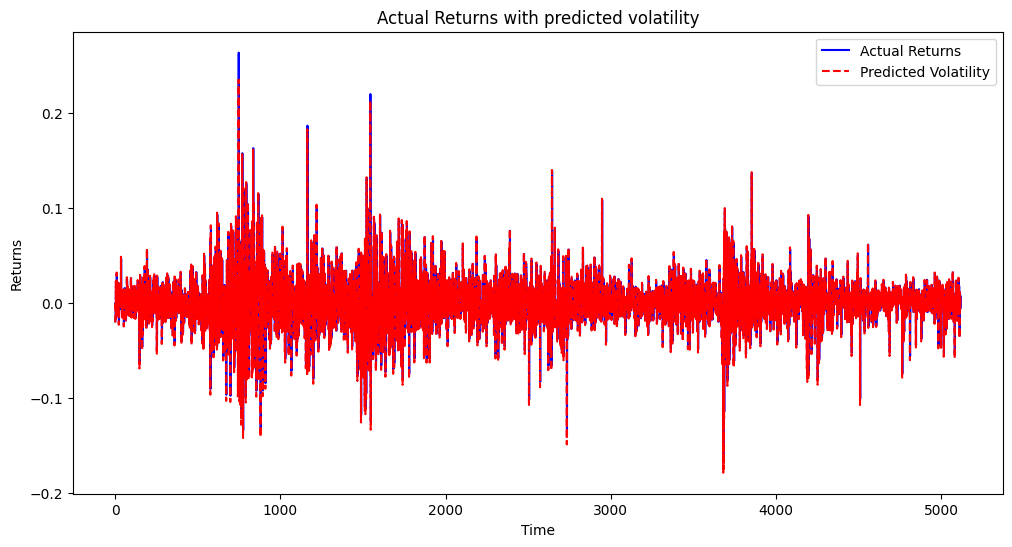

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(y_train, label='Actual Returns', color='blue')
#bon je comprend même pas pourquoi la volatilité est translatée d'une constante négative mais bon je l'ai enlevée pour comparer au rendements
plt.plot(y_pred-y_pred.mean(), label='Predicted Volatility', color='red', linestyle='--')
plt.title('Actual Returns with predicted volatility')
plt.xlabel('Time')
plt.ylabel('Returns')
plt.legend()
plt.show()

## code supplémentaire pour le lstm ( pas encore prêt )

In [ ]:
lstm.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.01),
    loss=weighted_mse,
    #metrics=[tf.keras.metrics.RootMeanSquaredError()] #ici il ne faut pas surveiller l'erreur car elle n'a aucun sens
)

In [ ]:
timesteps = 10  # par exemple, utiliser 10 jours passés

# Transformer les datasets
X_lstm, y_lstm = create_lstm_sequences(X, y, timesteps)

# Séparer train / test
test_size = 1500
X_train = X_lstm[test_size:, :, :]
y_train = y_lstm[test_size:, :]
X_test = X_lstm[:test_size, :, :]
y_test = y_lstm[:test_size, :]

In [ ]:
def create_lstm_sequences(X, y, timesteps=10):
    """
    Transforme X et y en séquences pour LSTM.
    X : (n_samples, 1) log-returns
    y : (n_samples, 1) returns
    timesteps : nombre de jours passés à utiliser pour prédire le prochain return
    """
    X_seq, y_seq = [], []

    for i in range(len(X) - timesteps):
        X_seq.append(X[i:i+timesteps, 0])  # séquence de log-returns
        y_seq.append(y[i+timesteps, 0])    # return du jour suivant

    X_seq = np.array(X_seq)
    y_seq = np.array(y_seq)

    # reshaper pour LSTM : (samples, timesteps, features)
    X_seq = X_seq.reshape((X_seq.shape[0], X_seq.shape[1], 1))
    y_seq = y_seq.reshape((-1, 1))

    return X_seq, y_seq

In [ ]:
"""timesteps = X_train.shape[1]  # nombre de jours dans la séquence
features = X_train.shape[2]   # ici 1 : log-return

# Définition du modèle
inputLSTM = Input(shape=(timesteps, features))
y = LSTM(200, return_sequences=True)(inputLSTM)  # première couche LSTM
y = LSTM(200)(y)                                 # deuxième couche LSTM
output = Dense(1)(y)                             # sortie unique : return du jour suivant

lstm = Model(inputs=inputLSTM, outputs=output)
lstm.summary()"""

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 10, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 10, 200)        │       161,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 200)            │       320,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           201 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 482,601 (1.84 MB)

 Trainable params: 482,601 (1.84 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
!git